In [1]:
from quantem.utils import (
    convert_to_PCS_circ,
    convert_to_ancilla_free_PCS_circ,
    check_to_ancilla_free_circ,
)

from quantem.pauli_checks import (
    ChecksFinder,
    add_pauli_checks,
    add_meas_pauli_checks,
    add_linear_meas_pauli_checks,
    search_for_pauli_list,
)
from quantem.pauli_checks import (
    gen_initial_layout,
    gen_final_layout,
    complete_postprocess,
    filter_results,
)

In [2]:
import qiskit
import qiskit_aer
from qiskit.quantum_info import hellinger_fidelity
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import QuantumCircuit

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import itertools

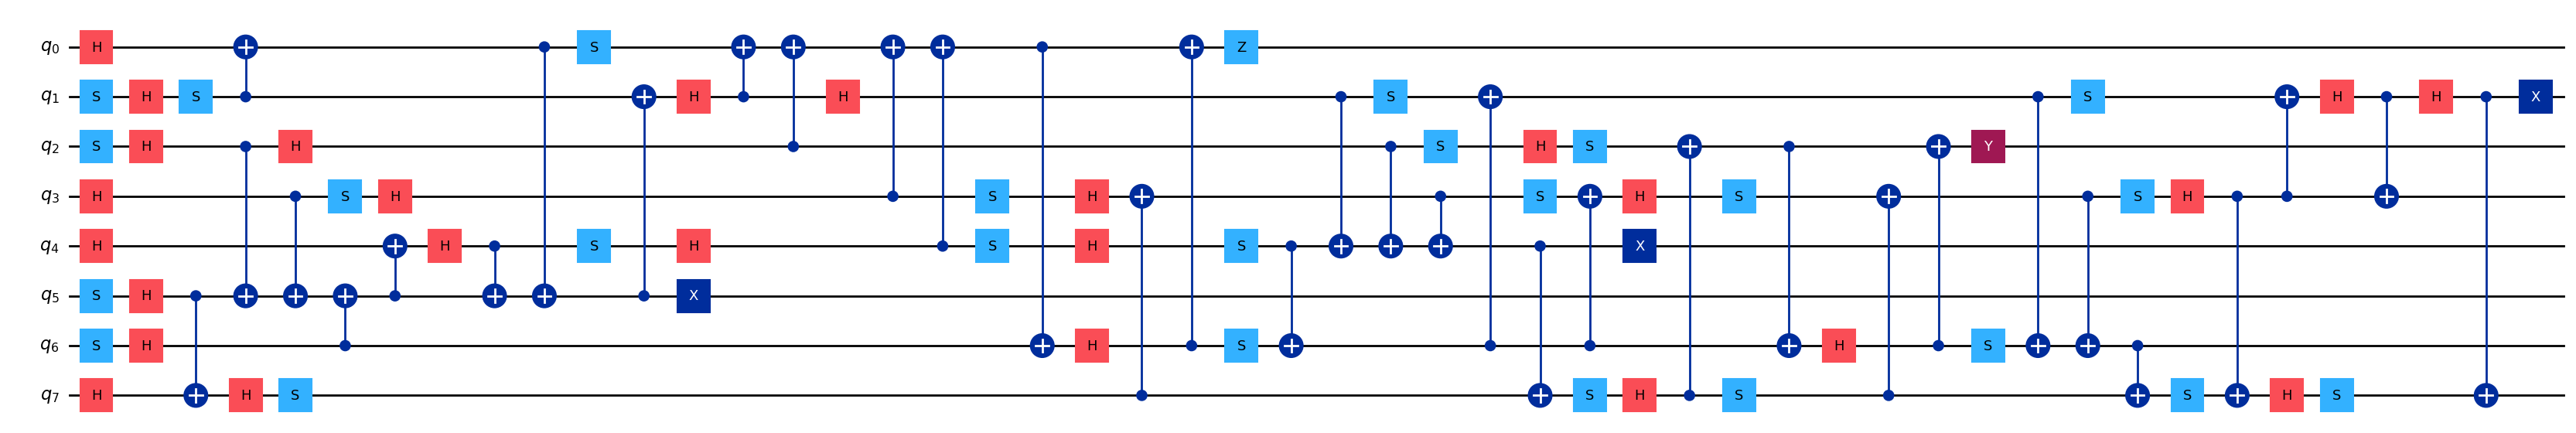

In [3]:
from qiskit.quantum_info import random_clifford

num_qubits = 8
clifford_obj = random_clifford(num_qubits)
circ = clifford_obj.to_circuit()
circ.draw("mpl", fold=-1)

### Generate PCS circ with desired number of check layers

In [4]:
num_checks = 4

sign_list, afpc_circ, left_checks, right_checks = convert_to_ancilla_free_PCS_circ(
    circ, num_qubits, num_checks, barriers=True
)

In [5]:
sign_list

['+1', '+1', '-1', '+1']

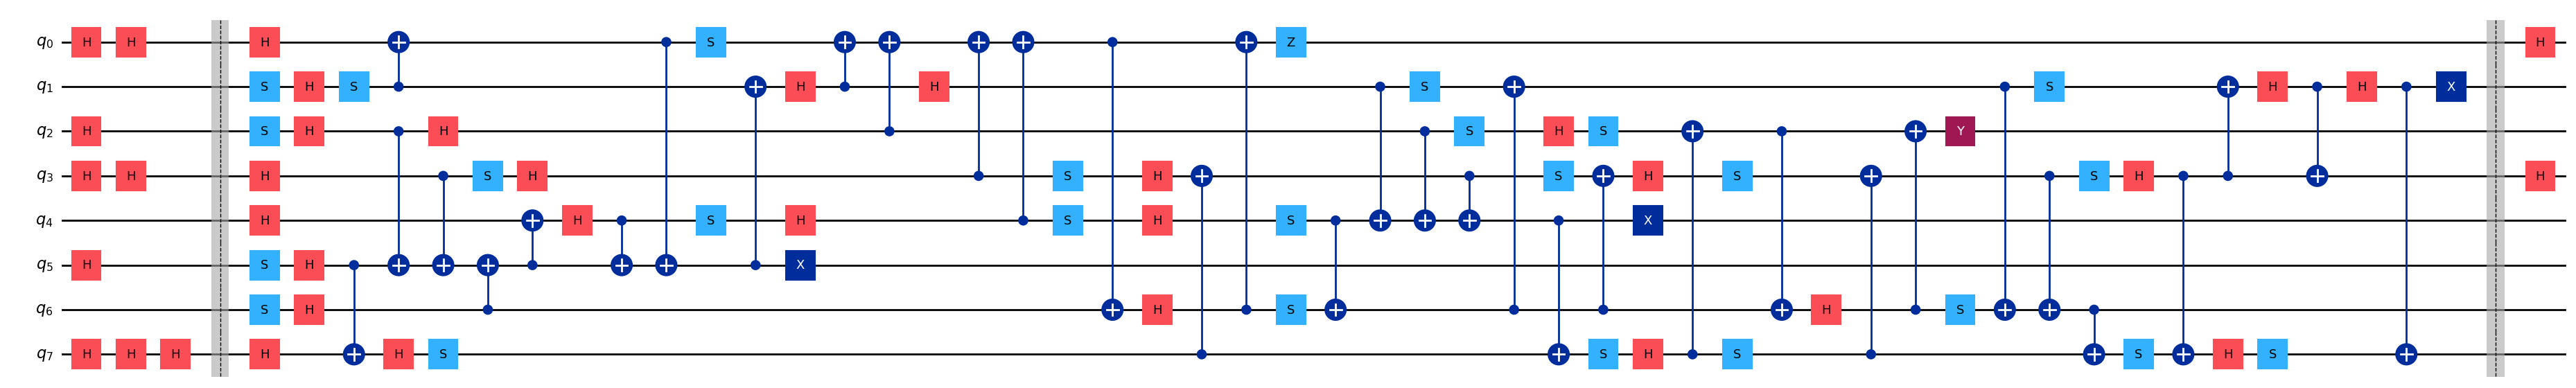

In [6]:
afpc_circ.draw("mpl", fold=-1)

In [7]:
left_checks  # original pauli checks applied to left side

[{6: 'Z', 4: 'Z'},
 {7: 'X', 6: 'Z', 5: 'X', 0: 'X'},
 {7: 'X', 3: 'X', 1: 'Z', 0: 'X'},
 {7: 'X', 3: 'X', 2: 'X'}]

In [8]:
right_checks  # original pauli checks applied to right side

[{0: 'X'}, {1: 'Z'}, {2: 'Z'}, {3: 'X'}]

#### Use right checks to filter counts

In [9]:
# def filter_afpc_counts(circ_qubits, right_mapping, in_counts):
#     filtered_counts = {}
#     removed_counts = 0
#     for bitstr, cnt in in_counts.items():
#         ones_count = 0
#         for q, check in right_mapping.items():
#             bit_index = circ_qubits - 1 - q
#             if bitstr[bit_index] == "1":
#                 ones_count += 1
#         if ones_count % 2 == 0:
#             filtered_counts[bitstr] = filtered_counts.get(bitstr, 0) + cnt
#         else:
#             removed_counts += cnt
#     return filtered_counts

#### Run afpc circuit and get percentage of discarded shots

In [10]:
# from qiskit_ibm_runtime.fake_provider import *

# backend = FakeBrisbane()
# shots = 10000
# circ = afpc_circ.copy()
# circ.measure_all()

# circ_transpiled = qiskit.transpile(
#         circ,
#         basis_gates=backend.configuration().basis_gates,
#         optimization_level=0,
#         # initial_layout=layout, comment out layout for purposes of this notebook
#         # coupling_map = fake_coupling_map,
#         backend=backend,
#         seed_transpiler=0
#     )

# print("number of two-qubit gates in transpiled circ: ")
# print(circ_transpiled.count_ops()["ecr"])

# noisy_sim = qiskit_aer.AerSimulator.from_backend(backend)
# counts = noisy_sim.run(circ_transpiled, shots=shots, seed_simulator=0).result().get_counts()

In [11]:
# sel_counts = filter_afpc_counts(num_qubits, right_checks, in_counts=counts)

# accepted_shots = sum(sel_counts.values())
# removed_counts = shots - accepted_shots
# print(f"removed counts: {removed_counts} ({removed_counts/shots * 100}%)")